In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transform3d
!pip install transforms3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.4 MB/s eta 0:00:00


In [17]:

import pickle
import autograd
import autograd.numpy as np
camdata = [] # [3×3×N numpy array (holding N rotation matrices)] [1×N numpy array of time stamps (unix time)] dict_keys(['cam', 'ts'])
imudata = [] # [Time Stamps Ax Ay Az Wx Wy Wz ]
vicondata = [] # [M×N×3×K numpy array (holding K RGB images)] [1×K numpy array of time stamps (unix time)] dict_keys(['rots', 'ts'])
# with open('/content/drive/MyDrive/ECE 276a/Project 1/trainset/cam/cam1.p', 'rb') as f:
#   camdata.append(pickle.load(f, encoding='latin1'))
# with open('/content/drive/MyDrive/ECE 276a/Project 1/trainset/cam/cam2.p', 'rb') as f:
#   camdata.append(pickle.load(f, encoding='latin1'))
# with open('/content/drive/MyDrive/ECE 276a/Project 1/trainset/cam/cam8.p', 'rb') as f:
#   camdata.append(pickle.load(f, encoding='latin1'))
# with open('/content/drive/MyDrive/ECE 276a/Project 1/trainset/cam/cam9.p', 'rb') as f:
#   camdata.append(pickle.load(f, encoding='latin1'))

#testdata
with open('/content/drive/MyDrive/ECE 276a/Project 1/trainset/cam/cam8.p', 'rb') as f:
  camdata.append(pickle.load(f, encoding='latin1'))
# with open('/content/drive/MyDrive/ECE 276a/Project 1/testset/cam/cam11.p', 'rb') as f:
#   camdata.append(pickle.load(f, encoding='latin1'))



# for i in range(9):
#   imufile = "/content/drive/MyDrive/ECE 276a/Project 1/trainset/imu/imuRaw" + str(i+1) + ".p"
#   with open(imufile, 'rb') as f:
#     imudata.append(pickle.load(f, encoding='latin1'))
#   viconfile = "/content/drive/MyDrive/ECE 276a/Project 1/trainset/vicon/viconRot" + str(i+1) +".p"
#   with open(viconfile, 'rb') as f:
#     vicondata.append(pickle.load(f, encoding='latin1'))
# imufile = "/content/drive/MyDrive/ECE 276a/Project 1/trainset/imu/imuRaw" + str(2) + ".p"
# with open(imufile, 'rb') as f:
#   imudata.append(pickle.load(f, encoding='latin1'))
viconfile = "/content/drive/MyDrive/ECE 276a/Project 1/trainset/vicon/viconRot" + str(2) +".p"
with open(viconfile, 'rb') as f:
  vicondata.append(pickle.load(f, encoding='latin1'))

#testdata
imufile = "/content/drive/MyDrive/ECE 276a/Project 1/testset/imu/imuRaw11.p"
with open(imufile, 'rb') as f:
  imudata.append(pickle.load(f, encoding='latin1'))

# Part 1

In [ ]:

import math
import transform3d as tf3d
import transforms3d as ts3d
def Norm(vector):
    return np.sqrt(np.sum(vector ** 2))

def Q_Mul(q,p):
  if(p.size==3):
    p = np.array[0,p[0],p[1],p[2]]
  Qs = q[0]*p[0] - np.dot(p[1:4], q[1:4])
  Qv = q[0]*p[1:4] + p[0]*q[1:4] + np.cross(q[1:4],p[1:4])
  return np.array([Qs,Qv[0],Qv[1],Qv[2]])

def Q_exp(vector_part):
    norm_v = Norm(vector_part)  # Norm of the vector part
    if norm_v == 0:
        return np.array([1.0, 0.0, 0.0, 0.0])  # Identity quaternion

    scalar_part = np.cos(norm_v)
    vector_part_normalized = vector_part / norm_v
    vector_result = vector_part_normalized * np.sin(norm_v)

    return np.concatenate(([scalar_part], vector_result))

def Q_next(q,ts,w):
    C=np.concatenate((np.array([0.]),(w * ts / 2))) #w has 3 elements
    return Q_Mul(q,Q_exp(C))
def trans2euler(q):
    w, x, y, z = q

    # roll
    sinr_cosp = 2.0 * (w * x + y * z)
    cosr_cosp = 1.0 - 2.0 * (x * x + y * y)
    roll = math.atan2(sinr_cosp, cosr_cosp)

    # pitch
    sinp = 2.0 * (w * y - z * x)
    if abs(sinp) >= 1:
        pitch = math.copysign(math.pi / 2, sinp)
    else:
        pitch = math.asin(sinp)

    # yaw
    siny_cosp = 2.0 * (w * z + x * y)
    cosy_cosp = 1.0 - 2.0 * (y * y + z * z)
    yaw = math.atan2(siny_cosp, cosy_cosp)

    return roll, pitch, yaw
def Q2acc(Q):
    G=np.array([0., 0., 0., -9.8])
    G=Q_Mul(G,Q)

    J=np.array([Q[0],-Q[1],-Q[2],-Q[3]])

    G=Q_Mul(J,G)
    return G

def Q_log(Q):

    Q = np.array(Q)


    q_scalar = Q[0]
    q_vector = Q[1:4]

    norm_Q = Norm(Q)
    norm_vector = Norm(q_vector)
    scalar_log = np.log(norm_Q)

    if norm_vector == 0:
        vector_log = np.zeros(3)
    else:
        angle = np.arccos(np.clip(q_scalar / norm_Q, -1.0, 1.0))
        vector_log = q_vector * (angle / norm_vector)

    return np.concatenate(([scalar_log], vector_log))

def cost_f(qk,tau_imu,imu_accerlation,IMU_len):
    q_ry=np.reshape(qk,(IMU_len,4))
    for i in range(IMU_len):
        if(i != IMU_len-1):
            qinv = np.array([q_ry[i+1][0],-q_ry[i+1][1],-q_ry[i+1][2],-q_ry[i+1][3]])
            q1=Norm(np.multiply(Q_log(Q_Mul((qinv),Q_next(q[i],tau_imu[i],ang_v[i]))),2))
            q1_sq= np.multiply(q1,q1)
            if (i==0):
                q1_seq=np.array([q1_sq])
            else:
                q1_seq=np.hstack((q1_seq,np.array([q1_sq])))
        ht=Q2acc(q_ry[i])[1:4]
        q2=Norm(np.subtract(imu_accerlation[i],ht))
        q2_sq= np.multiply(q2,q2)
        if (i==0):
            q2_seq=np.array([q2_sq])
        else:
            q2_seq=np.hstack((q2_seq,np.array([q2_sq])))




    A=1./2*np.sum(q1_seq)+1./2*np.sum(q2_seq)

    return A

def euler_to_quaternion(eulerangle):
    roll = eulerangle[0]
    pitch = eulerangle[1]
    yaw = eulerangle[2]
    c1 = np.cos(roll / 2)
    s1 = np.sin(roll / 2)
    c2 = np.cos(pitch / 2)
    s2 = np.sin(pitch / 2)
    c3 = np.cos(yaw / 2)
    s3 = np.sin(yaw / 2)

    w = c1 * c2 * c3 + s1 * s2 * s3
    x = s1 * c2 * c3 - c1 * s2 * s3
    y = c1 * s2 * c3 + s1 * c2 * s3
    z = c1 * c2 * s3 - s1 * s2 * c3

    return np.array([w, x, y, z])




In [ ]:
sc_ft_ang=3300/1023*(math.pi)/180/3.33
sc_ft_acc=3300/1023/300
fileindex = 0

IMU = imudata[fileindex].T # [Time Stamps Ax Ay Az Wx Wy Wz ]
ang_v=np.zeros((len(IMU),3),dtype=float)
imu_accerlation=np.zeros((len(IMU),3),dtype=float)
imu_timestamp=np.zeros((len(IMU),1),dtype=float)
imu_eulerang=np.zeros(((len(IMU)),3),dtype=float)
imu_timstanp=np.zeros(len(IMU)-1,dtype=float)

vic_eulerang=np.zeros(((len(vicondata[fileindex]['ts'].T)),3))
h=np.zeros((len(IMU),3),dtype=float)
q=np.zeros((len(IMU),4)) #q list
q[0]=np.array([1,0,0,0])

bias_ang_x=np.average(IMU[0:400,4])
bias_ang_y=np.average(IMU[0:400,5])
bias_ang_z=np.average(IMU[0:400,6])
bias_acc_x=np.average(IMU[0:400,1])
bias_acc_y=np.average(IMU[0:400,2])
bias_acc_z=np.average(IMU[0:400,3])



for j in range(len(IMU)):
  ang_v[j,0]=(IMU[j,4] - bias_ang_x) *sc_ft_ang
  ang_v[j,1]=(IMU[j,5] - bias_ang_y) *sc_ft_ang
  ang_v[j,2]=(IMU[j,6] - bias_ang_z) *sc_ft_ang
  imu_accerlation[j,0]=(IMU[j,1] - bias_acc_x)*sc_ft_acc
  imu_accerlation[j,1]=(IMU[j,2] - bias_acc_y)*sc_ft_acc
  imu_accerlation[j,2]=(IMU[j,3] - bias_acc_z)*sc_ft_acc
  if(j!=len(IMU)-1):
    imu_timestamp[j]=(IMU[j+1][0]-IMU[j][0])
    q[j+1]=Q_next(q[j],imu_timestamp[j],ang_v[j])
    Norm(q[j+1])
    imu_eulerang[j+1]=trans2euler(q[j+1])
  # h(qt)
  h[j] = Q2acc(q[j])[1:4]



for j in range(len(vicondata[fileindex]['ts'].T)) :
  vic_eulerang[j]=ts3d.euler.mat2euler(vicondata[fileindex]['rots'][:,:,j])


In [ ]:
# use cost_f to gradient descent

q_pl=np.reshape(q,4*len(IMU))
q_pl=q_pl+1e-4

cst=cost_f(q_pl,imu_timstanp,imu_accerlation,len(IMU))
grad_cost=autograd.grad(cost_f)

q_opt=np.copy(q_pl)
q_doc=np.copy(q_pl)
grad_cost = autograd.grad(cost_f)
for j in range(4):
    print("epoch:[%d]" % j)
    q_opt_ary = np.reshape(q_opt, (len(IMU), 4))
    grad_q = grad_cost(q_opt, imu_timestamp, imu_accerlation, len(IMU))
    grad_q_ary = np.reshape(grad_q, (len(IMU), 4))
    step = -0.1 * grad_q_ary
    no_c_q = q_opt_ary + step
    norm_val = np.sqrt(np.sum(no_c_q * no_c_q, axis=1)).reshape((len(IMU), 1))
    c_q = no_c_q / norm_val
    q_opt = c_q.reshape((4 * len(IMU)))





epoch:[0]
epoch:[1]
epoch:[2]
epoch:[3]


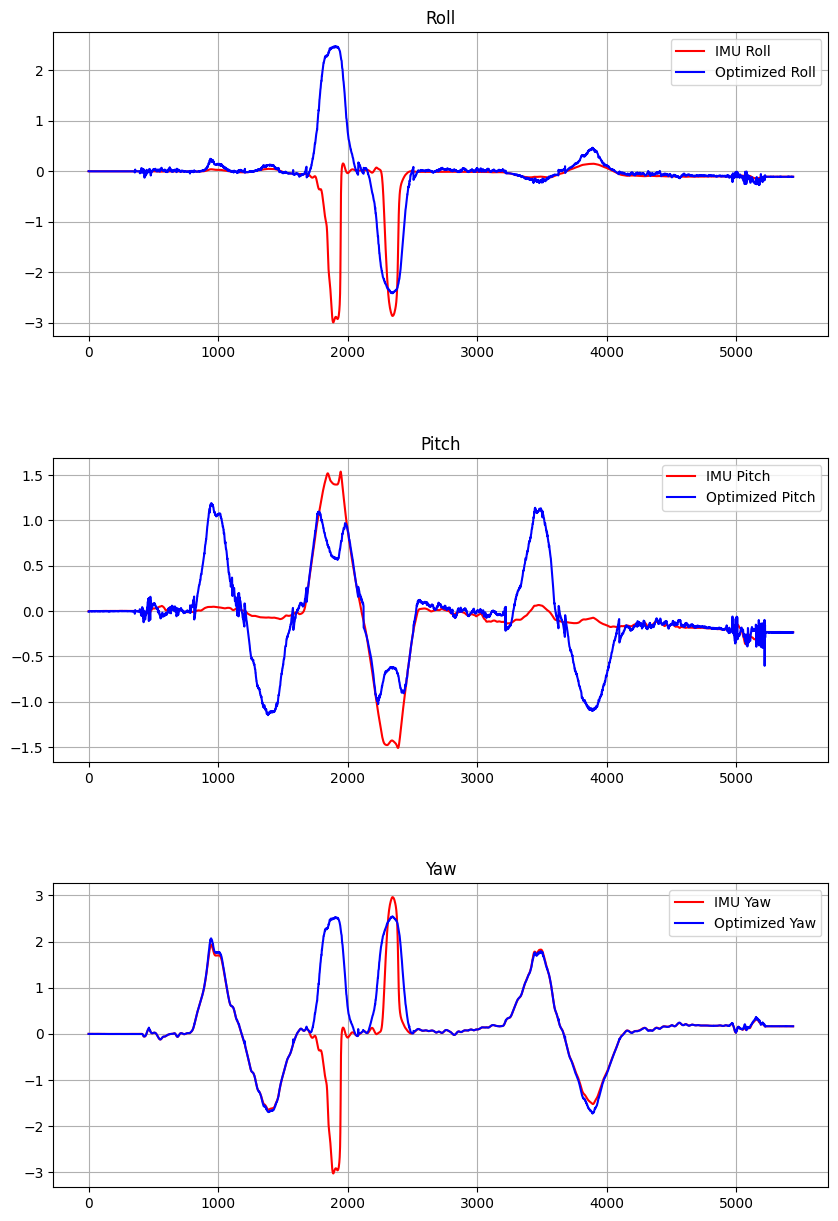

In [ ]:
import matplotlib.pyplot as plt

optimized_q_ang=np.zeros(((len(IMU)),3),dtype=float)
for i in range(len(IMU)):
  optimized_q_ang[i]=trans2euler(c_q[i]._value._value._value._value._value._value._value._value._value._value._value._value._value._value._value)

#draw plot
import numpy as np
import matplotlib.pyplot as plt

n1 = np.arange(0, len(IMU), 1)
n2 = np.arange(0, len(vicondata[fileindex]['ts'].T), 1)

fig, ax = plt.subplots(3, 1, figsize=(10, 15))
plt.subplots_adjust(wspace=0, hspace=0.4)


# ax[0].plot(n1, imu_eulerang.T[0], 'r', label="IMU Roll")
ax[0].plot(n2, vic_eulerang.T[0], 'g', label="Vicon Roll")
ax[0].plot(n1, optimized_q_ang.T[0], 'b', label="Optimized Roll")
ax[0].set_title("Roll")
ax[0].legend()
ax[0].grid()

# Pitch
# ax[1].plot(n1, imu_eulerang.T[1], 'r', label="IMU Pitch")
ax[1].plot(n2, vic_eulerang.T[1], 'g', label="Vicon Pitch")
ax[1].plot(n1, optimized_q_ang.T[1], 'b', label="Optimized Pitch")
ax[1].set_title("Pitch")
ax[1].legend()
ax[1].grid()

# Yaw
# ax[2].plot(n1, imu_eulerang.T[2], 'r', label="IMU Yaw")
ax[2].plot(n2, vic_eulerang.T[2], 'g', label="Vicon Yaw")
ax[2].plot(n1, optimized_q_ang.T[2], 'b', label="Optimized Yaw")
ax[2].set_title("Yaw")
ax[2].legend()
ax[2].grid()

plt.show()



# n1= np.arange(0,len(IMU) ,1)
# n2= np.arange(0,len(vicondata[fileindex]['ts'].T) ,1)
# plt.figure(figsize=(10,20))
# plt.subplots_adjust(wspace=0, hspace=0.5)
# a1=plt.subplot(3, 1, 1)
# linesList1=plt.plot(n1, imu_eulerang.T[0])
# linesList2=plt.plot(n2, vic_eulerang.T[0])
# plt.setp(linesList1, color='r')
# plt.setp(linesList2, color='b')
# a1.set_title("roll")
# linesList3=plt.plot(n1, optimized_q_ang.T[0])
# plt.setp(linesList1, color='r')
# plt.setp(linesList2, color='b')
# plt.setp(linesList3, color='g')
# a1.set_title("roll")

# n1= np.arange(0,len(IMU) ,1)
# n2= np.arange(0,len(vicondata[fileindex]['ts'].T) ,1)
# plt.figure(figsize=(10,20))
# plt.subplots_adjust(wspace=0, hspace=0.5)
# a1=plt.subplot(3, 1, 1)
# linesList1=plt.plot(n1, imu_eulerang.T[1])
# linesList2=plt.plot(n2, vic_eulerang.T[1])
# plt.setp(linesList1, color='r')
# plt.setp(linesList2, color='b')
# a1.set_title("pitch")
# linesList3=plt.plot(n1, optimized_q_ang.T[1])
# plt.setp(linesList1, color='r')
# plt.setp(linesList2, color='b')
# plt.setp(linesList3, color='g')
# a1.set_title("pitch")


# n1= np.arange(0,len(IMU) ,1)
# n2= np.arange(0,len(vicondata[fileindex]['ts'].T) ,1)
# plt.figure(figsize=(10,20))
# plt.subplots_adjust(wspace=0, hspace=0.5)
# a1=plt.subplot(3, 1, 1)
# linesList1=plt.plot(n1, imu_eulerang.T[2])
# linesList2=plt.plot(n2, vic_eulerang.T[2])
# plt.setp(linesList1, color='r')
# plt.setp(linesList2, color='b')
# a1.set_title("yaw")
# linesList3=plt.plot(n1, optimized_q_ang.T[2])
# plt.setp(linesList1, color='r')
# plt.setp(linesList2, color='b')
# plt.setp(linesList3, color='g')
# a1.set_title("yaw")

Part 2


In [ ]:
import math
from PIL import Image, ImageDraw
file_seq = 0
len_imu = len(imudata[file_seq][0].T)
len_cam = len(camdata[file_seq]['ts'].T)

IMU = imudata[file_seq].T
IMU_Time = imudata[file_seq][0].T
CAM = camdata[file_seq]['cam'].T
CAM_Time = camdata[file_seq]['ts'].T

match_seq = np.arange(len_cam)
i = 0
j = 0
while (i < len_imu and j < len_cam):
    # print(IMU_Time[i])
    # print(CAM_Time[j,0])
    # print("...")
    if (IMU_Time[i] < CAM_Time[j,0]):
        if (i == 0):
            cam_start = j
        i = i + 1
    else:
        match_seq[j] = i
        j = j + 1

    if (i == len_imu):
        cam_end = j - 1
    else:
        cam_end = len_cam - 1


In [18]:

q_opt = c_q._value._value._value._value._value._value._value._value._value._value._value._value._value._value._value
# for j in range(len(vic_eulerang)):
#   q_opt[j]=euler_to_quaternion(vic_eulerang[j])
#   q_opt[j]=Norm(q_opt[j])

optimized_q_ang=np.zeros(((len(vic_eulerang)),3),dtype=float)
for j in range(len(vic_eulerang)):
  optimized_q_ang[j]=vic_eulerang[j]

max_index = q_opt.shape[0] - 1
match_seq_modified = np.clip(match_seq[cam_start:(cam_end+1)], 0, max_index)

q_opt_modified = q_opt[match_seq_modified, :]
T = len(match_seq_modified)

camd_modified=CAM[:,:,:,cam_start:(cam_end+1)]
print("camd_modified shape:",camd_modified.shape)
R=np.zeros((T,3,3))
#create R
k=0
while(k<T):
    R[k,:,:]=ts3d.quaternions.quat2mat(q_opt_modified[k,:])
    k=k+1
k=0
sphere_b=np.zeros((240,320,3));
for i in range(240):
    for j in range(320):
        sphere_b[i,j,:]=np.array([(-math.pi/6+math.pi/960*(0.5+j)),(math.pi/8+math.pi/960*(-0.5-i)) ,1.])
#sphere to cartisian
cart_b=np.zeros((240,320,3));
for i in range(240):
    for j in range(320):
        cart_b[i,j,:]=np.array([(math.cos(sphere_b[i,j,1])*math.cos(sphere_b[i,j,0])), (math.cos(sphere_b[i,j,1])*math.sin(sphere_b[i,j,0])), math.sin(sphere_b[i,j,1])])

#R(x,y,z)s
i=0
cart_s=[]
while(i<T):
    cart_b_mult=cart_b.reshape(240,320,3,1)
    cart_s_0=np.matmul(R[i,:,:],cart_b_mult)
    cart_s_1=cart_s_0.reshape(240,320,3)
    cart_s.append(cart_s_1)
    i=i+1
cart_s=np.stack(cart_s,axis=-1)

#convert the world frame to sphere,then convert to cylinder coordinates
canvas=np.arange(960*1920*3).reshape(960,1920,3)
sph_s=np.arange(240*320*3*T).reshape(240,320,3,T)
sph_s=sph_s.astype('float32')
cyl_s=np.arange(240*320*2*T).reshape(240,320,2,T)
cyl_s=cyl_s.astype('int')
i=0
while(i<T):
    for j in range(240):
        for k in range(320):
            if(cart_s[j,k,0,i]>0):
                if(cart_s[j,k,1,i]==0):
                    sph_s[j,k,0,i]=0
                elif(cart_s[j,k,1,i]>0):
                    sph_s[j,k,0,i]=math.atan((cart_s[j,k,1,i]/cart_s[j,k,0,i]))
                else:
                    sph_s[j,k,0,i]=math.atan((cart_s[j,k,1,i]/cart_s[j,k,0,i]))+2*math.pi
            else:
                if(cart_s[j,k,1,i]==0):
                    sph_s[j,k,0,i]=math.pi
                else:
                    sph_s[j,k,0,i]=math.atan((cart_s[j,k,1,i]/cart_s[j,k,0,i]))+math.pi
            sph_s[j,k,1,i]=math.acos(cart_s[j,k,2,i])
            sph_s[j,k,2,i]=1.
                                                            #convert to cylinder
            cyl_s[j,k,0,i]=math.floor(sph_s[j,k,0,i]/(2*math.pi)*1919)
            cyl_s[j,k,1,i]=math.floor(sph_s[j,k,1,i]/(math.pi)*959)

    i=i+1

camd_modified shape: (161, 3, 320, 161)


ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
import math
import transforms3d as ts3d
import matplotlib.pyplot as plt

import autograd
import autograd.numpy as np1
from PIL import Image, ImageDraw
cam = camd_modified.T
#define canvas RGB
canvas=np.zeros((960,1920,3))
canvas=canvas.astype('int')
i=0
while(i<T):
    for j in range(240):
        for k in range(320):

            canvas[cyl_s[j,k,1,i],cyl_s[j,k,0,i],0]=int(cam[j,k,0,i])
            canvas[cyl_s[j,k,1,i],cyl_s[j,k,0,i],1]=int(cam[j,k,1,i])
            canvas[cyl_s[j,k,1,i],cyl_s[j,k,0,i],2]=int(cam[j,k,2,i])


    i=i+1








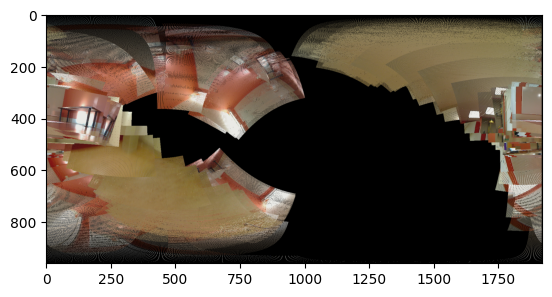

In [ ]:
fig = plt.figure()
im1=plt.imshow(canvas)
plt.show()